In [1]:
import sys
import os
import base64
import pickle
import zlib
import gym
import numpy as np
import pandas as pd
import torch as th
from torch import nn, tensor
from collections import deque
from gym.spaces import Box, Discrete
from gfootball.env import create_environment, observation_preprocessing, wrappers
from stable_baselines3 import PPO
from stable_baselines3.ppo import CnnPolicy
from stable_baselines3.common import results_plotter
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.vec_env.dummy_vec_env import DummyVecEnv
from stable_baselines3.common.vec_env.subproc_vec_env import SubprocVecEnv
from stable_baselines3.common.vec_env.base_vec_env import VecEnv
from stable_baselines3.common.policies import BasePolicy, register_policy
from IPython.display import HTML
import time
from datetime import date
from matplotlib import pyplot as plt
from stable_baselines3 import DQN
import torch
%matplotlib inline

In [2]:
torch.manual_seed(42)
torch.manual_seed(torch.initial_seed())

---
# Football Gym

In [3]:
class FootballGym(gym.Env):
    spec = None
    metadata = None
#     metadata = {'render.modes': ['human']}
    def __init__(self, config=None, render=False, rewards='scoring'):
        super(FootballGym, self).__init__()
        env_name = "academy_empty_goal_close"
        rewards = rewards
        if config is not None:
            env_name = config.get("env_name", env_name)
            rewards = config.get("rewards", rewards)
        self.env = create_environment(
            env_name=env_name,
            stacked=False,
            representation="simple115v2",
            rewards = rewards,
            write_goal_dumps=False,
            write_full_episode_dumps=False,
            render=render,
            write_video=False,
            dump_frequency=1,
            logdir=".",
            extra_players=None,
            number_of_left_players_agent_controls=1,
            number_of_right_players_agent_controls=0)
        self.action_space = self.env.action_space
        self.observation_space = self.env.observation_space
        self.reward_range = (-1, 1)
        self.obs_stack = deque([], maxlen=4)
        
    def reset(self):
        self.obs_stack.clear()
        obs = self.env.reset()
        return obs
    
    def step(self, action):
        obs, reward, done, info = self.env.step([action])
        return obs, float(reward), done, info
    

### Creating the DDQN Model

In [4]:
from torch.nn import functional as F

class DDQN(DQN):
    def train(self, gradient_steps: int, batch_size: int = 100) -> None:
        # Switch to train mode (this affects batch norm / dropout)
        self.policy.set_training_mode(True)
        # Update learning rate according to schedule
        self._update_learning_rate(self.policy.optimizer)

        losses = []
        for _ in range(gradient_steps):
            ### YOUR CODE HERE
            # Sample replay buffer
            replay_data = self.replay_buffer.sample(batch_size, env=self._vec_normalize_env)

            # Do not backpropagate gradient to the target network
            with th.no_grad():
                # Compute the next Q-values using the target network
                next_q_values = self.q_net_target(replay_data.next_observations)
        
                # Decouple action selection from value estimation
                # Compute q-values for the next observation using the online q net
                next_q_values_online = self.q_net(replay_data.next_observations)

                # Select action with online network
                next_actions_online = next_q_values_online.argmax(dim=1)

                # Estimate the q-values for the selected actions using target q network
                next_q_values = th.gather(next_q_values, dim=1, index=next_actions_online.unsqueeze(-1))
               
                # 1-step TD target
                target_q_values = replay_data.rewards + (1 - replay_data.dones) * self.gamma * next_q_values

            # Get current Q-values estimates
            current_q_values = self.q_net(replay_data.observations)

            # Retrieve the q-values for the actions from the replay buffer
            current_q_values = th.gather(current_q_values, dim=1, index=replay_data.actions.long())

            # Check the shape
            assert current_q_values.shape == target_q_values.shape

            # Compute Huber loss (less sensistive to outliers)
            loss = F.smooth_l1_loss(current_q_values, target_q_values)
            
            # Using KL-loss with Huber Loss.
            # Uncomment this line if you want to use KL loss along with Huber loss
#             kl_loss = th.nn.KLDivLoss(reduction="batchmean")
#             loss = loss + kl_loss(F.log_softmax(current_q_values), F.softmax(target_q_values))
            
            # KL-loss only
#             loss =  kl_loss(F.log_softmax(current_q_values), F.softmax(target_q_values))
            
            losses.append(loss.item())

            # Optimize the q-network
            self.policy.optimizer.zero_grad()
            loss.backward()
            
            # Clip gradient norm
            th.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
            self.policy.optimizer.step()

        # Increase update counter
        self._n_updates += gradient_steps
        self.logger.record("train/n_updates", self._n_updates, exclude="tensorboard")
        self.logger.record("train/loss", np.mean(losses))

### Environment creation and logging

In [5]:
scenarios = {0: "academy_empty_goal_close",
             1: "academy_empty_goal",
             2: "academy_run_to_score",
             3: "academy_run_to_score_with_keeper",
             4: "academy_pass_and_shoot_with_keeper",
             5: "academy_run_pass_and_shoot_with_keeper",
             6: "academy_3_vs_1_with_keeper",
             7: "academy_corner",
             8: "academy_counterattack_easy",
             9: "academy_counterattack_hard",
             10: "academy_single_goal_versus_lazy",
             11: "11_vs_11_kaggle",
             12: "11_vs_11_stochastic",
             13: "11_vs_11_easy_stochastic",
             14: "11_vs_11_hard_stochastic"}

scenario_name = scenarios[13]

In [6]:
from typing import Callable
from stable_baselines3.common.utils import set_random_seed
def make_env(config: dict, rank: int, log_save_dir: str, seed: int = 42) -> Callable:
    """
    Utility function for multiprocessed env.
    
    :param env_id: (str) the environment ID
    :param num_env: (int) the number of environment you wish to have in subprocesses
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    :return: (Callable)
    """
    def _init() -> gym.Env:
        env = FootballGym(config, rewards='scoring')
#         env = FootballGym(config, rewards='scoring,checkpoints')
        log_file = os.path.join(log_save_dir, str(rank))
        env = Monitor(env, log_file, allow_early_resets=True)
        env.seed(seed + rank)
        return env
    set_random_seed(seed)
    return _init

In [7]:
# Creating the vectorized training environmewnt and also creating the direcotry for logging

timestamp = time.strftime('%d-%m-%Y-%H-%M-%S', time.localtime())
print(timestamp)

n_envs = 8
config={"env_name":scenario_name}
log_save_dir = os.path.join("../logs/dqn_logs", timestamp)
print(f"Log dir: {log_save_dir}")
os.mkdir(log_save_dir)
train_env = SubprocVecEnv([make_env(config, rank=i, log_save_dir=log_save_dir) for i in range(n_envs)])

27-05-2022-01-27-38
Log dir: ../logs/dqn_logs/27-05-2022-01-27-38


### Initializing the Vanilla DQN model
--- 
Uncomment the following cell if you want to use the vanilla DQN instead of Double DQN

In [8]:
# Configuring the DQN net like SB3's network structure
# Only one layer for the feature extraction and the rest for the Q value computation
# from stable_baselines3 import DQN

# policy_kwargs = dict(
#     net_arch = [1024, 1024, 1024],
#     activation_fn = torch.nn.GELU
# )
# model_name = "dqn"
# model = DQN(policy="MlpPolicy", 
#             env=train_env, 
#             policy_kwargs=policy_kwargs, 
#             verbose=1,
#             exploration_initial_eps=0.00,
#             exploration_final_eps=0.0,
#             target_update_interval=15000,
# #             learning_rate=hparams['lr'],
# #             batch_size=hparams['batch_size'],
#             seed=42,
#             tensorboard_log='tb_logs_DQN',
#             learning_starts=100000,
#            )
# model.policy
           

### Double DQN

In [9]:
# DDQN

policy_kwargs = dict(
    net_arch = [1024, 1024, 1024],
    activation_fn = torch.nn.ReLU
)

# policy_kwargs = dict(features_extractor_class=FootballMLP,
#                      features_extractor_kwargs=dict(features_dim=1024),
#                     net_arch = [],
#                     )
model_name = "ddqn"
model = DDQN(policy="MlpPolicy", 
            env=train_env, 
            policy_kwargs=policy_kwargs, 
            verbose=1,
            exploration_initial_eps=0.05,
            exploration_final_eps=0.05,
            target_update_interval=150000,
#             learning_rate=0.0000001,
#             batch_size=hparams['batch_size'],
            seed=42,
            tensorboard_log='../logs/tb_logs_DDQN',
            train_freq=3002,
#             learning_starts=100000,
           )

model.policy
           

Using cuda device


DQNPolicy(
  (q_net): QNetwork(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (q_net): Sequential(
      (0): Linear(in_features=115, out_features=1024, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.25, inplace=False)
      (3): Linear(in_features=1024, out_features=1024, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.25, inplace=False)
      (6): Linear(in_features=1024, out_features=1024, bias=True)
      (7): ReLU()
      (8): Dropout(p=0.25, inplace=False)
      (9): Linear(in_features=1024, out_features=19, bias=True)
    )
  )
  (q_net_target): QNetwork(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (q_net): Sequential(
      (0): Linear(in_features=115, out_features=1024, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.25, inplace=False)
      (3): Linear(in_features=1024, out_features=1024, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.25, inp

In [10]:
model.policy.state_dict()

OrderedDict([('q_net.q_net.0.weight',
              tensor([[ 0.0713,  0.0774, -0.0218,  ...,  0.0287, -0.0870, -0.0612],
                      [-0.0310,  0.0146, -0.0821,  ...,  0.0340, -0.0650, -0.0920],
                      [-0.0757,  0.0695,  0.0448,  ..., -0.0473, -0.0831, -0.0754],
                      ...,
                      [ 0.0181, -0.0042,  0.0872,  ..., -0.0375,  0.0428, -0.0366],
                      [ 0.0651, -0.0373, -0.0710,  ..., -0.0832, -0.0721, -0.0251],
                      [ 0.0364,  0.0165, -0.0706,  ..., -0.0749, -0.0038, -0.0388]],
                     device='cuda:0')),
             ('q_net.q_net.0.bias',
              tensor([ 0.0160, -0.0134,  0.0441,  ..., -0.0526,  0.0454,  0.0675],
                     device='cuda:0')),
             ('q_net.q_net.3.weight',
              tensor([[-0.0255,  0.0123,  0.0094,  ...,  0.0126, -0.0018, -0.0055],
                      [-0.0208, -0.0291,  0.0197,  ..., -0.0082,  0.0235, -0.0024],
                      [-0

#### Loading IL agent's weights
---
Download the checkpoints from here: [IL agent checkpoints](https://drive.google.com/drive/folders/1QwyPsWdGfJMhjEcBIhNot15iij_VRx_U?usp=sharing)

Modify the path of the checkpoints

In [11]:
# IL agent with BN
# checkpoint_path = "../il_agent_checkpoints/epoch=208-step=681548.ckpt"

# IL agent without BN
checkpoint_path = "../il_agent_checkpoints/epoch=146-step=479366.ckpt"
checkpoint_dict = torch.load(checkpoint_path)
checkpoint_dict

{'epoch': 147,
 'global_step': 479367,
 'pytorch-lightning_version': '1.5.10',
 'state_dict': OrderedDict([('model.0.weight',
               tensor([[-1.2712,  1.7235, -0.8170,  ..., -0.7283, -1.0528, -0.3971],
                       [ 0.2426, -0.4846, -0.1319,  ..., -0.3745,  0.1083, -0.1955],
                       [ 0.1865, -0.4384,  0.2724,  ...,  0.0148, -0.0946, -0.1312],
                       ...,
                       [ 0.9357, -2.8718, -1.0750,  ..., -1.5358,  0.2322, -0.8907],
                       [ 2.0421, -4.0784, -1.6789,  ..., -0.9545,  0.5744,  0.2149],
                       [ 1.1143,  1.9087,  0.0565,  ..., -0.2459, -0.7759, -0.8163]],
                      device='cuda:0')),
              ('model.0.bias',
               tensor([-0.6341, -0.3114, -0.1605,  ..., -0.9393, -2.3791, -0.4585],
                      device='cuda:0')),
              ('model.3.weight',
               tensor([[-1.1699,  0.0614, -0.0255,  ..., -0.2109, -3.2698, -1.0542],
                    

In [12]:
mlp_keys_todqn_keys_dict = {}
sd_dqn_model = model.policy.state_dict()
count = 0
for mlp_key, dqn_key in zip(checkpoint_dict['state_dict'].keys(), model.policy.q_net.state_dict().keys()):
    sd_dqn_model['q_net.' + dqn_key] = checkpoint_dict['state_dict'][mlp_key]
for mlp_key, dqn_key in zip(checkpoint_dict['state_dict'].keys(), model.policy.q_net_target.state_dict().keys()):
    sd_dqn_model['q_net_target.' + dqn_key] = checkpoint_dict['state_dict'][mlp_key]
    
model.policy.load_state_dict(sd_dqn_model)

# Check the model's weights after loading the weights from IL agent
model.policy.state_dict()

OrderedDict([('q_net.q_net.0.weight',
              tensor([[-1.2712,  1.7235, -0.8170,  ..., -0.7283, -1.0528, -0.3971],
                      [ 0.2426, -0.4846, -0.1319,  ..., -0.3745,  0.1083, -0.1955],
                      [ 0.1865, -0.4384,  0.2724,  ...,  0.0148, -0.0946, -0.1312],
                      ...,
                      [ 0.9357, -2.8718, -1.0750,  ..., -1.5358,  0.2322, -0.8907],
                      [ 2.0421, -4.0784, -1.6789,  ..., -0.9545,  0.5744,  0.2149],
                      [ 1.1143,  1.9087,  0.0565,  ..., -0.2459, -0.7759, -0.8163]],
                     device='cuda:0')),
             ('q_net.q_net.0.bias',
              tensor([-0.6341, -0.3114, -0.1605,  ..., -0.9393, -2.3791, -0.4585],
                     device='cuda:0')),
             ('q_net.q_net.3.weight',
              tensor([[-1.1699,  0.0614, -0.0255,  ..., -0.2109, -3.2698, -1.0542],
                      [ 0.0258, -0.0823, -0.1066,  ..., -0.0416, -0.0200, -0.0641],
                      [ 0

##### Freezing the layers

In [13]:
# # For freezing the layers

# for idx, param in enumerate(model.policy.parameters()):
# #     if param.shape == torch.Size([19, 1024]) or param.shape == torch.Size([19]):
#     if param.shape == torch.Size([19]):
#         print(param.shape, param.requires_grad)
#         param.requires_grad = True
#     else:
#         param.requires_grad = False
#         #     print(param.shape)

In [14]:
# for idx, param in enumerate(model.policy.parameters()):
#     print(param.shape, param.requires_grad)

---
# Training

In [15]:
from tqdm.notebook import tqdm
class ProgressBar(BaseCallback):
    def __init__(self, verbose=0):
        super(ProgressBar, self).__init__(verbose)
        self.pbar = None

    def _on_training_start(self):
        factor = np.ceil(self.locals['total_timesteps'] / n_steps)
        print(f"self.locals['total_timesteps']:{self.locals['total_timesteps']}, n_steps: {n_steps}")
        n = 1
        try:
            n = len(self.training_env.envs)
        except AttributeError:
            try:
                n = len(self.training_env.remotes)
            except AttributeError:
                n = 1
        total = int(n_steps * factor / n)
        self.pbar = tqdm(total=total)

    def _on_rollout_start(self):
        self.pbar.refresh()

    def _on_step(self):
        self.pbar.update(1)
        return True

    def _on_rollout_end(self):
        self.pbar.refresh()

    def _on_training_end(self):
        self.pbar.close()
        self.pbar = None

progressbar = ProgressBar()

In [16]:
total_epochs = 1
n_steps = 3002
total_timesteps = n_steps * n_envs * total_epochs
model.learn(total_timesteps=total_timesteps, callback=progressbar, log_interval=8, tb_log_name='ddqn-test')


saved_model_name = model_name + '_gfootball_' + str(n_envs) + "_" + timestamp
model.save(f"../models/{model_name}/{saved_model_name}")

---> OffpolicyAlgorithm.learn():
Logging to ../logs/tb_logs_DDQN/ddqn-test_3
self.locals['total_timesteps']:24016, n_steps: 3002


  0%|          | 0/3002 [00:00<?, ?it/s]

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3e+03    |
|    ep_rew_mean      | -0.125   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 421      |
|    time_elapsed     | 56       |
|    total_timesteps  | 24008    |
----------------------------------


### Visualization with Tensorboard

In [17]:
%load_ext tensorboard

In [18]:
%tensorboard --logdir ../logs/tb_logs_DDQN

### Visualizing the results

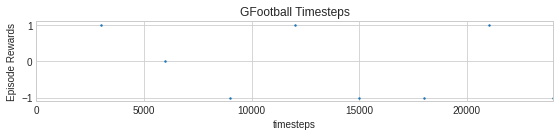

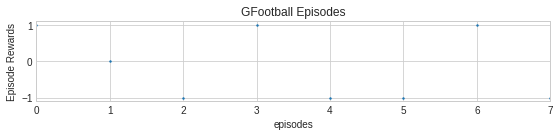

In [19]:
# Plot the rewards per timestep and per episode

plt.style.use(['seaborn-whitegrid'])
results_plotter.plot_results([log_save_dir], total_timesteps, results_plotter.X_TIMESTEPS, "GFootball Timesteps")
# plt.savefig('../figures/dqn/rewards_per_timestamp_dqn_with_my_policy.png')
results_plotter.plot_results([log_save_dir], total_timesteps, results_plotter.X_EPISODES, "GFootball Episodes")
# plt.savefig('../figures/dqn/rewards_per_episode_dqn_with_my_policy.png')

Text(0, 0.5, 'Episode Rewards')

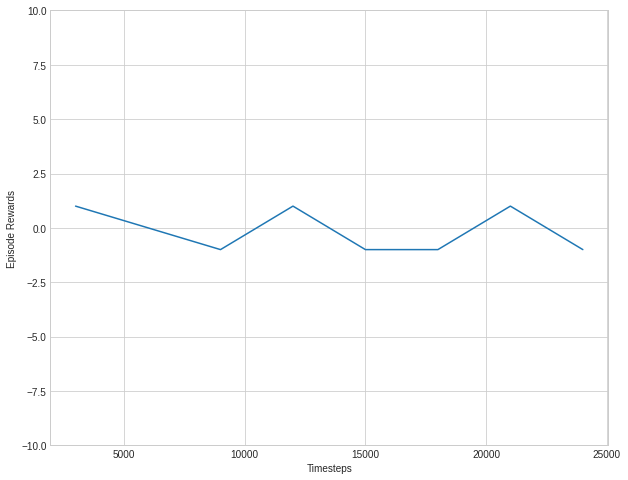

In [21]:
# Plot the episodic reward with line

x, y = results_plotter.ts2xy(results_plotter.load_results(log_save_dir), 'timesteps')  # Organising the logged results in to a clean format for plotting.
fig = plt.figure(figsize=(10, 8))
plt.plot(x,y)
plt.ylim([-10, 10])
plt.xlabel('Timesteps')
plt.ylabel('Episode Rewards')

/tmp/ipykernel_31390/1048478977.py:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nrows, 2, i+1, label=log_file)
/tmp/ipykernel_31390/1048478977.py:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nrows, 2, i+1, label=log_file)
/tmp/ipykernel_31390/1048478977.py:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nrows, 2, i+1, label=log_file)
/tmp/ipykernel_31390/1048478977.py:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nrows, 2, i+1, label=log_file)
/tmp/ipykernel_31390

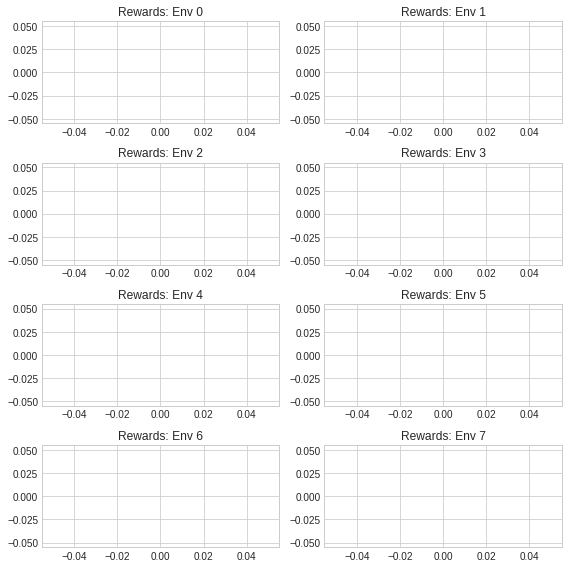

In [22]:
# Plot the rolling mean reward per environment

plt.style.use(['seaborn-whitegrid'])
log_files = [os.path.join(log_save_dir, f"{i}.monitor.csv") for i in range(n_envs)]

nrows = np.ceil(n_envs/2)
fig = plt.figure(figsize=(8, 2 * nrows))
for i, log_file in enumerate(log_files):
    if os.path.isfile(log_file):
        df = pd.read_csv(log_file, skiprows=1)
        plt.subplot(nrows, 2, i+1, label=log_file)
        df['r'].rolling(window=5).mean().plot(title=f"Rewards: Env {i}")
        plt.tight_layout()
plt.show()

In [ ]:
# Plot the mean episodic reward
# Download the CSV from tensorboard and put the path here
df = pd.read_csv('data_for_figures/run-ddqn_3-tag-rollout_ep_rew_mean.csv')
fig = plt.figure(figsize=(10, 8))
df.plot(x ='Step', y='Value')
# plt.savefig('../figures/dqn/mean_ep_reward_with_IL_50_epochs_diff_net.jpg')